In [43]:
import torch
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import cv2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [44]:
train_data = datasets.CIFAR10(root="data",
                              train=True,
                              download=True,
                              transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root="data",
                             train=False,
                             download=True,
                             transform=transforms.ToTensor())

train = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=False)
test = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [45]:
class_dict = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

for data in train:
    Xs, ys = data
    for y in ys:
        class_dict[int(y)] += 1
print(class_dict)


{0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}


In [46]:
for data in train:
    Xs, ys = data
    print(Xs[0].shape)
    break


torch.Size([3, 32, 32])


In [47]:
import torch.nn.functional as F


class Net(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, 5, bias=False)
        self.batch_norm1 = torch.nn.BatchNorm2d(32)
        self.conv2 = torch.nn.Conv2d(32, 64, 5)
        self.batch_norm2 = torch.nn.BatchNorm2d(64)
        self.dropout1 = torch.nn.Dropout2d(0.25)

        x = torch.rand(3, 32, 32).view(-1, 3, 32, 32)
        self._to_linear = None
        self.convs(x)

        self.fc1 = torch.nn.Linear(self._to_linear, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.fc3 = torch.nn.Linear(64, 10)

    def convs(self, x):
        x = F.relu(self.batch_norm1(self.conv1(x)))
        x = F.max_pool2d(x, (2, 2))
        x = self.dropout1(x)
        x = F.relu(self.batch_norm2(self.conv2(x)))
        x = F.max_pool2d(x, (2, 2))
        self._to_linear = x[0].shape[0]*x[0].shape[1] * \
            x[0].shape[2]  # Channels * width * height
        print(self._to_linear)

    def forward(self, x):
        x = F.relu(self.batch_norm1(self.conv1(x)))
        x = F.max_pool2d(x, (2, 2))
        x = self.dropout1(x)
        x = F.relu(self.batch_norm2(self.conv2(x)))
        x = F.max_pool2d(x, (2, 2))
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.log_softmax(self.fc3(x), dim=1)
        return x


model = Net().to(device)
print(model)


1600
Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [48]:
class Config():
    def __init__(self) -> None:
        self.epochs = 30
        self.Batchsize = 32


config = Config()


In [49]:
from torchsummary import summary
summary(model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]           2,400
       BatchNorm2d-2           [-1, 32, 28, 28]              64
         Dropout2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 10, 10]          51,264
       BatchNorm2d-5           [-1, 64, 10, 10]             128
            Linear-6                  [-1, 128]         204,928
            Linear-7                   [-1, 64]           8,256
           Dropout-8                   [-1, 64]               0
            Linear-9                   [-1, 10]             650
Total params: 267,690
Trainable params: 267,690
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.53
Params size (MB): 1.02
Estimated Total Size (MB): 1.56
-------------------------------------------

In [50]:
valsize = int(len(train)*0.1)  # Reserve %10 for validation
trainsize = len(train) - valsize  # Reserve %90 for train
print(valsize, trainsize)
train_set, val_set = torch.utils.data.random_split(train, [trainsize, valsize])


156 1407


In [51]:
for data in train_set.dataset:
    Xs, ys = data
    print(Xs.shape, ys.shape)
    break


torch.Size([32, 3, 32, 32]) torch.Size([32])


In [52]:
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()


100%|██████████| 1563/1563 [00:18<00:00, 83.67it/s]


Epoch 1: Loss - 1.643088808749169, Validation Loss - 1.3312578284427743


100%|██████████| 1563/1563 [00:18<00:00, 84.38it/s]


Epoch 2: Loss - 1.359170958390239, Validation Loss - 1.0864570816205392


100%|██████████| 1563/1563 [00:18<00:00, 84.70it/s]


Epoch 3: Loss - 1.2232228897354653, Validation Loss - 0.9714954842837743


100%|██████████| 1563/1563 [00:18<00:00, 84.49it/s]


Epoch 4: Loss - 1.1322705913680682, Validation Loss - 0.9763905617264853


100%|██████████| 1563/1563 [00:18<00:00, 85.21it/s]


Epoch 5: Loss - 1.0611574029167417, Validation Loss - 0.8409592303151285


100%|██████████| 1563/1563 [00:19<00:00, 81.90it/s]


Epoch 6: Loss - 0.9976021184115859, Validation Loss - 0.8230194450950135


100%|██████████| 1563/1563 [00:20<00:00, 77.10it/s]


Epoch 7: Loss - 0.9526102795520045, Validation Loss - 0.7704043253941637


100%|██████████| 1563/1563 [00:21<00:00, 71.49it/s]


Epoch 8: Loss - 0.9108101616703541, Validation Loss - 0.7194536358060855


100%|██████████| 1563/1563 [00:21<00:00, 72.44it/s]


Epoch 9: Loss - 0.8713211059494043, Validation Loss - 0.699657365736943


100%|██████████| 1563/1563 [00:20<00:00, 76.12it/s]


Epoch 10: Loss - 0.8393424297858718, Validation Loss - 0.6871143079917551


100%|██████████| 1563/1563 [00:20<00:00, 77.45it/s]


Epoch 11: Loss - 0.8051744624543328, Validation Loss - 0.5888760244034074


100%|██████████| 1563/1563 [00:20<00:00, 77.17it/s]


Epoch 12: Loss - 0.7856841650115169, Validation Loss - 0.5757008603918804


100%|██████████| 1563/1563 [00:20<00:00, 76.03it/s]


Epoch 13: Loss - 0.7545962318615965, Validation Loss - 0.5633139877043241


100%|██████████| 1563/1563 [00:20<00:00, 76.61it/s]


Epoch 14: Loss - 0.7335616480976209, Validation Loss - 0.5524553673071352


100%|██████████| 1563/1563 [00:20<00:00, 77.70it/s]


Epoch 15: Loss - 0.7083610927189151, Validation Loss - 0.5117097737521448


100%|██████████| 1563/1563 [00:19<00:00, 80.62it/s]


Epoch 16: Loss - 0.6937460190236988, Validation Loss - 0.49285687427069236


100%|██████████| 1563/1563 [00:20<00:00, 77.29it/s]


Epoch 17: Loss - 0.6717744039005754, Validation Loss - 0.4553416031564724


100%|██████████| 1563/1563 [00:23<00:00, 67.93it/s]


Epoch 18: Loss - 0.6582369067237229, Validation Loss - 0.47102129078986776


100%|██████████| 1563/1563 [00:20<00:00, 74.77it/s]


Epoch 19: Loss - 0.6369017325794551, Validation Loss - 0.4357632081419401


100%|██████████| 1563/1563 [00:21<00:00, 73.19it/s]


Epoch 20: Loss - 0.6210698680719807, Validation Loss - 0.4284136174622058


100%|██████████| 1563/1563 [00:19<00:00, 79.69it/s]


Epoch 21: Loss - 0.6052624087110973, Validation Loss - 0.4230092900566237


100%|██████████| 1563/1563 [00:20<00:00, 77.47it/s]


Epoch 22: Loss - 0.6003283915787421, Validation Loss - 0.40595201782820245


100%|██████████| 1563/1563 [00:19<00:00, 79.56it/s]


Epoch 23: Loss - 0.5811894066388685, Validation Loss - 0.3836134832712297


100%|██████████| 1563/1563 [00:19<00:00, 80.79it/s]


Epoch 24: Loss - 0.5723679638154905, Validation Loss - 0.38884762750124596


100%|██████████| 1563/1563 [00:19<00:00, 81.87it/s]


Epoch 25: Loss - 0.5599317826659574, Validation Loss - 0.40525372807348836


100%|██████████| 1563/1563 [00:20<00:00, 77.83it/s]


Epoch 26: Loss - 0.5465061936196195, Validation Loss - 0.34677128968563736


100%|██████████| 1563/1563 [00:25<00:00, 60.63it/s]


Epoch 27: Loss - 0.5347172489970141, Validation Loss - 0.3511016465918955


100%|██████████| 1563/1563 [00:23<00:00, 66.88it/s]


Epoch 28: Loss - 0.5268672732392031, Validation Loss - 0.3287193140090084


100%|██████████| 1563/1563 [00:22<00:00, 70.24it/s]


Epoch 29: Loss - 0.5200666627028548, Validation Loss - 0.3052949188128161


100%|██████████| 1563/1563 [00:22<00:00, 68.57it/s]


Epoch 30: Loss - 0.5119584288950998, Validation Loss - 0.32040795813518996


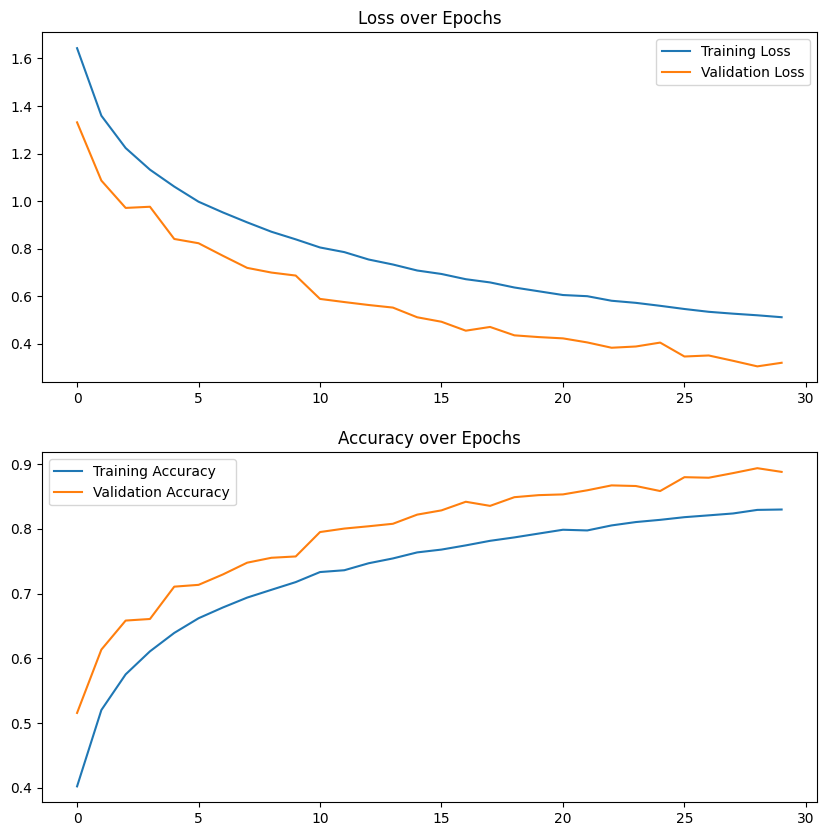

In [53]:
def plot_loss_acc(train_loss, val_loss, train_acc, val_acc):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    axs[0].plot(train_loss, label='Training Loss')
    axs[0].plot(val_loss, label='Validation Loss')
    axs[0].set_title('Loss over Epochs')
    axs[0].legend()

    axs[1].plot(train_acc, label='Training Accuracy')
    axs[1].plot(val_acc, label='Validation Accuracy')
    axs[1].set_title('Accuracy over Epochs')
    axs[1].legend()

    plt.show()


def training(model, loss_fn, optimizer, train_set, val_set):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(config.epochs):
        train_loss = 0
        train_acc = 0
        model.train()
        for data in tqdm(train_set.dataset):
            Xs, ys = data
            Xs = Xs.to(device)
            ys = ys.to(device)
            model.zero_grad()
            outputs = model(Xs)
            loss = loss_fn(outputs, ys)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate accuracy
            _, predictions = torch.max(outputs, 1)
            train_acc += (predictions == ys).sum().item() / ys.shape[0]

        train_loss /= len(train_set.dataset)
        train_acc /= len(train_set.dataset)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss = 0
        val_acc = 0
        for data in val_set.dataset:
            Xs, ys = data
            Xs = Xs.to(device)
            ys = ys.to(device)
            outputs = model(Xs)
            loss = loss_fn(outputs, ys)
            val_loss += loss.item()

            # Calculate accuracy
            _, predictions = torch.max(outputs, 1)
            val_acc += (predictions == ys).sum().item() / ys.shape[0]

        val_loss /= len(val_set.dataset)
        val_acc /= len(val_set.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(
            f"Epoch {epoch+1}: Loss - {train_loss}, Validation Loss - {val_loss}")

    plot_loss_acc(train_losses, val_losses, train_accs, val_accs)


training(model, loss_fn, optimizer, train_set, val_set)


Initially, overfitting was observed in the model, leading to poor performance on unseen data. To mitigate this, dropout and L2 regularization were added to the model architecture. However, this resulted in underfitting, indicating that the model is not complex enough to capture the underlying patterns in the data. To improve performance, an additional 10 epochs of training will be performed to allow the model to better fit the data.

100%|██████████| 1563/1563 [00:23<00:00, 67.69it/s]


Epoch 1: Loss - 0.4930866918051693, Validation Loss - 0.30726998918573595


100%|██████████| 1563/1563 [00:24<00:00, 64.90it/s]


Epoch 2: Loss - 0.4836122878920704, Validation Loss - 0.2888281037190825


100%|██████████| 1563/1563 [00:23<00:00, 67.54it/s]


Epoch 3: Loss - 0.47269458274618603, Validation Loss - 0.2733788332917983


100%|██████████| 1563/1563 [00:22<00:00, 70.71it/s]


Epoch 4: Loss - 0.46249951265861955, Validation Loss - 0.2897055060844046


100%|██████████| 1563/1563 [00:19<00:00, 79.86it/s]


Epoch 5: Loss - 0.4521927775568445, Validation Loss - 0.2893633416574389


100%|██████████| 1563/1563 [00:20<00:00, 75.08it/s]


Epoch 6: Loss - 0.4506075918788873, Validation Loss - 0.2567790465433


100%|██████████| 1563/1563 [00:27<00:00, 56.37it/s]


Epoch 7: Loss - 0.43895158233146064, Validation Loss - 0.2586718454494624


100%|██████████| 1563/1563 [00:23<00:00, 67.38it/s]


Epoch 8: Loss - 0.4348345020462974, Validation Loss - 0.25893144247313377


100%|██████████| 1563/1563 [00:23<00:00, 67.39it/s]


Epoch 9: Loss - 0.4203170331711008, Validation Loss - 0.25881867919663015


100%|██████████| 1563/1563 [00:18<00:00, 82.60it/s]


Epoch 10: Loss - 0.4137430601155651, Validation Loss - 0.22916646157191758


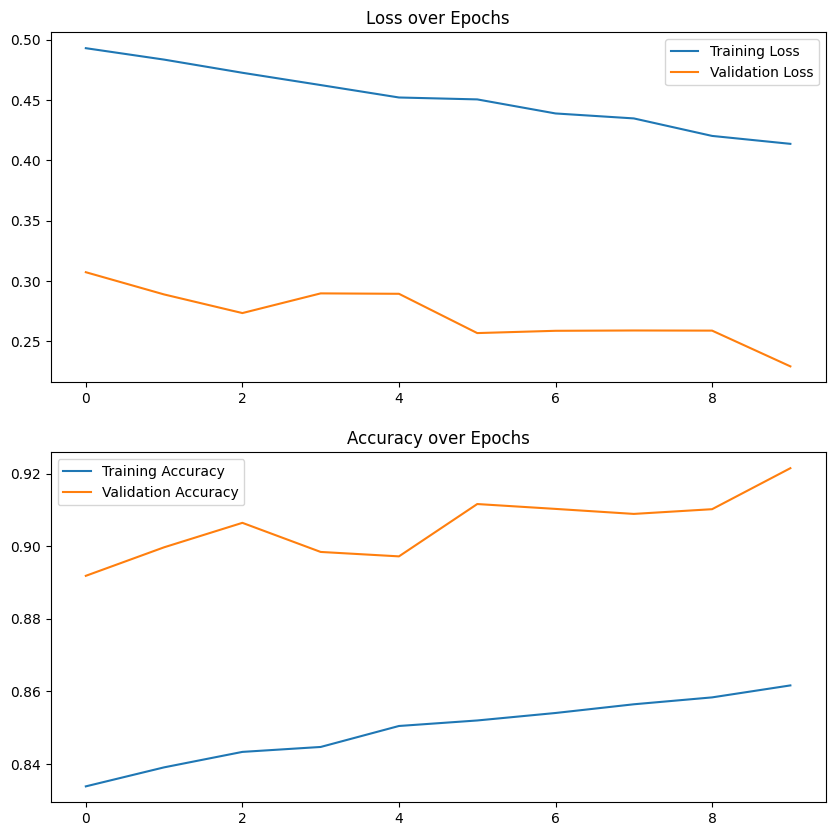

In [55]:
config.epochs = 10
training(model, loss_fn, optimizer, train_set, val_set)


In [60]:
model.eval()  # set the model to evaluation mode
with torch.no_grad():  # set the torch gradient calculation to be off
    correct = 0
    total = 0
    for data in test:
        Xs, ys = data
        Xs = Xs.to(device)
        ys = ys.to(device)
        outputs = model(Xs)
        _, predicted = torch.max(outputs.data, 1)
        total += ys.size(0)
        correct += (predicted == ys).sum().item()
    test_accuracy = correct/total
    print("Test accuracy: ", test_accuracy)


Test accuracy:  0.7156
